from best_test_root
change layer from 5-layer to 4-layer
change batch size both to 128

In [12]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader


calculate the mean and standard deviation values, which then can use in the transforms.Normalize function.

In [15]:
import numpy as np
import torchvision.datasets as datasets

# Load the CIFAR-10 training dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True)

# Stack all the images into a single large numpy array
images = np.stack([np.array(image) for image, _ in cifar10_train])

# Calculate the mean and standard deviation for each channel
mean = images.mean(axis=(0, 1, 2)) / 255
std = images.std(axis=(0, 1, 2)) / 255

print("Mean:", mean)
print("Standard Deviation:", std)


Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


By normalizing the input data, you ensure that the values lie in a similar range, which helps the neural network learn the features more effectively. This is particularly important when working with images, as the pixel values can vary greatly depending on the content and lighting conditions. Normalizing the data helps mitigate these differences and makes the training process more stable.

In [16]:
# data augmentation part
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #randomly changes the brightness, contrast, and saturation of an image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2434, 0.2615)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2434, 0.2615)),
])


In [17]:
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


what is a good batch size to start with?

In [18]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [22]:
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

class ModifiedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ModifiedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ModifiedResNet(nn.Module): ## need some initialization control
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_channels = 32 ##change
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2, bias=False)##change
        self.bn1 = nn.BatchNorm2d(32)##change
        self.relu = nn.ReLU(inplace=True)

        ##change
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        #self.layer5 = self._make_layer(block, 256, num_blocks[4], stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, num_classes) #a fully connected layer

        #ensure that the neural network is initialized properly before training
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = self.layer5(out)
        out = self.gap(out)
        #out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [23]:
def ModifiedResNet18():
    #return ModifiedResNet(ModifiedResidualBlock, [2, 2, 2, 2, 3])
    return ModifiedResNet(ModifiedResidualBlock, [2, 2, 2, 2]) 
    ## this could be changed

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ModifiedResNet18().to(device)

# Get the summary
input_shape = (3, 32, 32)  # (channels, height, width)
summary(model, input_shape, device=device)

##change
#optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
##could change the scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=0)
#scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[15,25,30],gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,400
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
ModifiedResidualBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1,

In [25]:
num_epochs = 70
best_accuracy = 0.0  # Initialize the best accuracy variable
save_path = 'best_model.pth'  # Specify the path where the best model will be saved

train_losses = []
test_accuracies = []
learning_rates = []


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = nn.CrossEntropyLoss()(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()

    # Test accuracy evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), save_path)
    # Append training loss after each batch
    train_losses.append(loss.item())

    # Append test accuracy after each epoch
    test_accuracies.append(accuracy)

    # Append learning rate after each epoch
    learning_rates.append(scheduler.get_last_lr()[0])



Epoch [1/70], Accuracy: 0.3171
Epoch [2/70], Accuracy: 0.4528
Epoch [3/70], Accuracy: 0.5233
Epoch [4/70], Accuracy: 0.5815
Epoch [5/70], Accuracy: 0.6693
Epoch [6/70], Accuracy: 0.6773
Epoch [7/70], Accuracy: 0.7419
Epoch [8/70], Accuracy: 0.7519
Epoch [9/70], Accuracy: 0.7921
Epoch [10/70], Accuracy: 0.8050
Epoch [11/70], Accuracy: 0.8161
Epoch [12/70], Accuracy: 0.8410
Epoch [13/70], Accuracy: 0.8523
Epoch [14/70], Accuracy: 0.8597
Epoch [15/70], Accuracy: 0.8677
Epoch [16/70], Accuracy: 0.8725
Epoch [17/70], Accuracy: 0.8774
Epoch [18/70], Accuracy: 0.8763
Epoch [19/70], Accuracy: 0.8797
Epoch [20/70], Accuracy: 0.8844
Epoch [21/70], Accuracy: 0.8890
Epoch [22/70], Accuracy: 0.8865
Epoch [23/70], Accuracy: 0.8918
Epoch [24/70], Accuracy: 0.8908
Epoch [25/70], Accuracy: 0.8936
Epoch [26/70], Accuracy: 0.8959
Epoch [27/70], Accuracy: 0.8915
Epoch [28/70], Accuracy: 0.8946
Epoch [29/70], Accuracy: 0.8944
Epoch [30/70], Accuracy: 0.8941
Epoch [31/70], Accuracy: 0.8947
Epoch [32/70], Ac

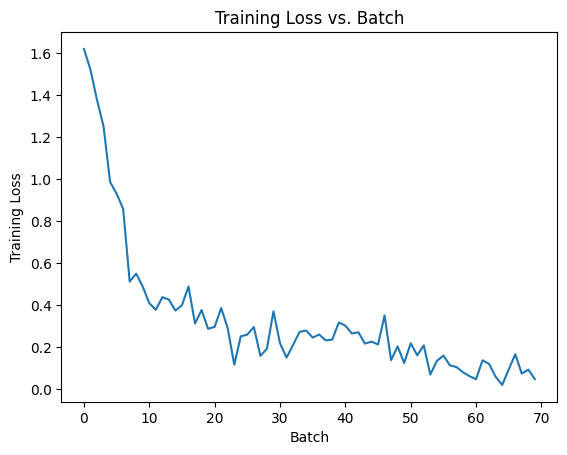

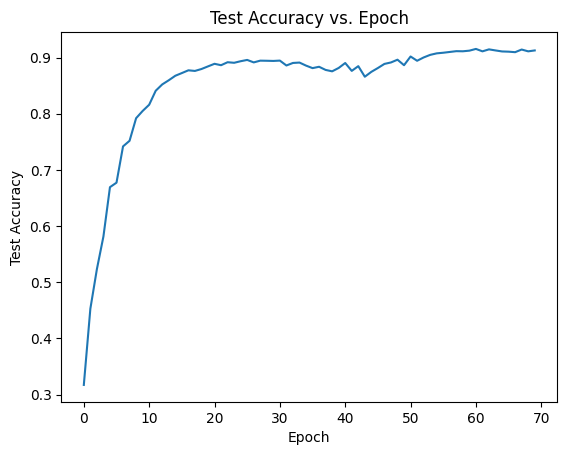

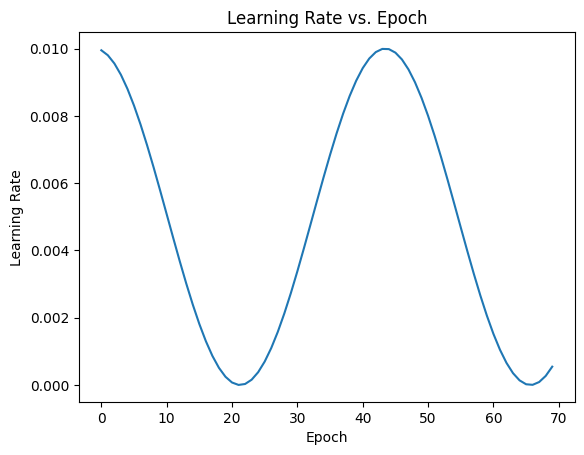

In [26]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure()
plt.plot(train_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Batch')

# Plot test accuracy
plt.figure()
plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epoch')

# Plot learning rate
plt.figure()
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs. Epoch')

plt.show()
